# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import jax

plt.style.use('seaborn')

In [2]:
## Adding the g2o to homogeneous coordinates codes

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []
    info_matrix = []

    for line in A:
        if "EDGE_SE2" in line:
            (_, ind1, ind2, dx, dy, dtheta, a1, a2, a3, b2, b3, c3) = line.split()
            a1 = float(a1)
            a2 = float(a2)
            a3 = float(a3)
            b2 = float(b2)
            b3 = float(b3)
            c3 = float(c3)
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
            info_matrix.append(jnp.array([[a1,a2,a3],[a2,b2,b3],[a3,b3,c3]]))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta),jnp.array(info_matrix))

In [3]:
edges = readEdge('../data/edges.txt')
pose_init = readVertex('../data/edges.txt')
#pose_init = pose_init.reshape((-1,1))

In [4]:
## Getting the poses

for i in range(edges[0].shape[0]):
    if edges[1][i] - edges[0][i] == 1:
        theta = pose_init[-1][-1]
        x = pose_init[0][-1] + edges[2][i]*jnp.cos(theta) - edges[3][i]*jnp.sin(theta)
        y = pose_init[1][-1] + edges[2][i]*jnp.sin(theta) + edges[3][i]*jnp.cos(theta)
        pose_init = jnp.append(pose_init,jnp.array([ x,y,theta + edges[4][i]]).reshape((-1,1)),axis=1)

In [5]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def draw_all(pose,X, Y, THETA):
    ax = plt.subplot(111)

    # Ground Truth
    gt = readVertex('../data/gt.txt')
    
    ax.plot(gt[0], gt[1], 'ro')
    ax.plot(gt[0], gt[1], 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(gt[3][i]) + gt[0][i]
        y2 = 0.25*math.sin(gt[3][i]) + gt[1][i]
        plt.plot([gt[0][i], x2], [gt[1][i], y2], 'b->')

    # Noisy Start Truth
    
    ax.plot(pose[0], pose[1], 'ro')
    ax.plot(pose[0], pose[1], 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(pose[3][i]) + pose[0][i]
        y2 = 0.25*math.sin(pose[3][i]) + pose[1][i]
        plt.plot([pose[0][i], x2], [pose[1][i], y2], 'r->')

    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    # Optimized
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    blue_patch = mpatches.Patch(color='blue', label='Ground Truth')
    red_patch = mpatches.Patch(color='red', label='Initial Estimate')
    green_patch = mpatches.Patch(color='green', label='Optimised Trajectory')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    plt.show()

## Initial Pose

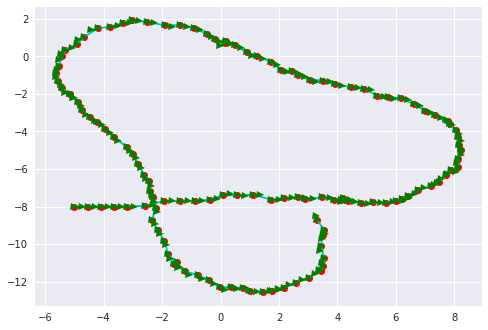

In [7]:
draw(pose_init[0],pose_init[1],pose_init[2])

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [8]:
## Hyperparameters

lm_lambda = 1
iters = 100

## Defining the Anchor
anchor = pose_init[:,0]

## Adding weight of the anchor to the information matrix
inf_matrix = jnp.insert(edges[-1],0,jnp.diag(jnp.array([2000,2000,2000])),axis = 0)

In [9]:
## Reshaping Information Matrix
diag = jnp.array([])

for i in range(inf_matrix.shape[0]):
    diag = jnp.append(diag,jnp.array([inf_matrix[i][0][0]]*3))

inf_matrix = jnp.diag(diag)

In [10]:
def res_fn(edges,pose,anchor):
    f = jnp.array([])

    # Anchor Condition
    f = jnp.append(f,pose[:,0] - anchor)
    f = f.reshape((-1,1))

    # Going using current pose difference and coming back using odometry to get the error
    for i in range(edges[0].shape[0]):
        theta = pose[:,edges[0][i]][-1] # Current Angle
        x = pose[:,edges[0][i]][0] + edges[2][i]*jnp.cos(theta) - edges[3][i]*jnp.sin(theta)
        y = pose[:,edges[0][i]][1] + edges[2][i]*jnp.sin(theta) + edges[3][i]*jnp.cos(theta)
        estimate = jnp.array([ x,y,theta + edges[4][i]]).reshape((-1,1))

        f = jnp.append(f,estimate - pose[:,edges[1][i]].reshape((-1,1)),axis=1)
    return f

def jacobian(pose,edges):
    J = jnp.zeros(((edges[0].shape[0] + 1)*3,pose.shape[1]*3))
    
    # Anchor Jacobian
    J = J.at[0,0].set(1)
    J = J.at[1,1].set(1)
    J = J.at[2,2].set(1)

    # Other Edges
    for i in range(edges[0].shape[0]):
        ind1 = edges[0][i]
        ind2 = edges[1][i]
        theta = pose[:,ind1][-1]

        # partial differenciation with itself => 1
        J = J.at[(i+1)*3,ind1*3].set(1)
        J = J.at[(i+1)*3+1,ind1*3+1].set(1)
        J = J.at[(i+1)*3+2,ind1*3+2].set(1)

        # partial differenciation wrt theta
        J = J.at[(i+1)*3,ind1*3+2].set(-edges[2][i]*jnp.sin(theta) - edges[3][i]*jnp.cos(theta))
        J = J.at[(i+1)*3+1,ind1*3+2].set(edges[2][i]*jnp.cos(theta) - edges[3][i]*jnp.sin(theta))

        # partial differenciation wrt to ind2
        J = J.at[(i+1)*3,ind2*3].set(-1)
        J = J.at[(i+1)*3 + 1,ind2*3 + 1].set(-1)
        J = J.at[(i+1)*3 + 2,ind2*3 + 2].set(-1)

    return J

def error_fn(pose,edges,anchor,inf_matrix):
    r = res_fn(edges,pose,anchor)
    r = r.reshape((-1,1)).T

    return 1/2 * r@inf_matrix@r.T

def levenberg(pose,edges,anchor,inf_matrix,lm_lambda):
    J = jacobian(pose,edges)
    r = res_fn(edges,pose,anchor).T.reshape((-1,1))

    return - (jnp.linalg.inv(J.T@inf_matrix@J +lm_lambda*jnp.eye(J.shape[1]))@J.T@inf_matrix.T@r).reshape((-1,3))

In [13]:
def optimize(pose,edges,anchor,inf_matrix,num_iters = iters,lm = lm_lambda,tol = 1e-6,verbose = True):
    poses = [pose]
    error = [error_fn(poses[-1],edges,anchor,inf_matrix)]
    
    if verbose:
        print('Initial Guess,',end='')
        print('Error : ',error[-1][0][0])
        draw(poses[-1][0],poses[-1][1],poses[-1][2])

    for i in range(num_iters):
        poses.append(poses[-1] + levenberg(poses[-1],edges,anchor,inf_matrix,lm).T)
        error.append(error_fn(poses[-1],edges,anchor,inf_matrix))

        if verbose:
            print('Iteration : ',i,',',end='')
            print('Error : ',error[-1][0][0])
            if i%10 == 0:
                draw_all(poses[0],poses[-1][0],poses[-1][1],poses[-1][2])

        if error[-1] > error[-2]:
            lm *= 2
        else:
            lm /= 3

        if jnp.linalg.norm(poses[-1] - poses[-2]) < tol:
            break

    return poses,error
        

Initial Guess,Error :  [559097.1]


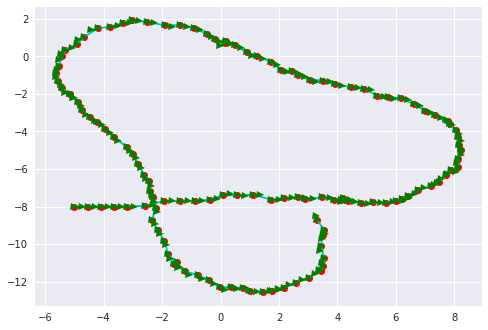

Iteration :  0 ,Error :  [79827.8]


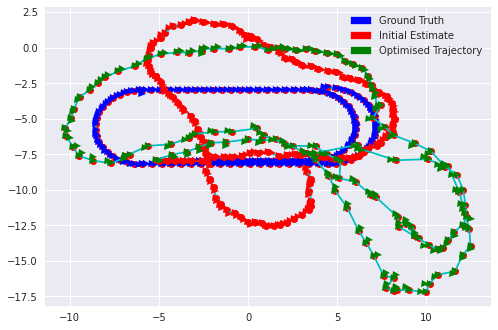

Iteration :  1 ,Error :  [5148.9]
Iteration :  2 ,Error :  [5415.443]
Iteration :  3 ,Error :  [1098.4503]
Iteration :  4 ,Error :  [1085.6494]
Iteration :  5 ,Error :  [1157.094]
Iteration :  6 ,Error :  [736.00104]
Iteration :  7 ,Error :  [836.92896]
Iteration :  8 ,Error :  [541.8276]
Iteration :  9 ,Error :  [535.48175]
Iteration :  10 ,Error :  [479.2475]


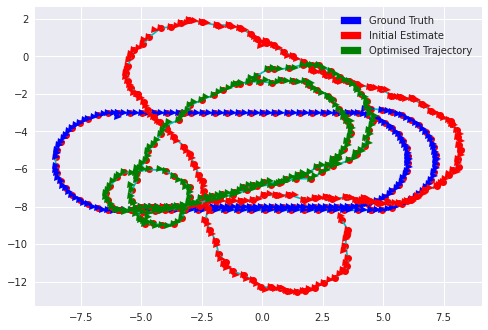

Iteration :  11 ,Error :  [467.44736]
Iteration :  12 ,Error :  [464.0447]
Iteration :  13 ,Error :  [463.6893]
Iteration :  14 ,Error :  [463.88577]
Iteration :  15 ,Error :  [464.16434]
Iteration :  16 ,Error :  [464.3848]
Iteration :  17 ,Error :  [464.54398]
Iteration :  18 ,Error :  [464.6506]
Iteration :  19 ,Error :  [464.72092]
Iteration :  20 ,Error :  [464.76596]


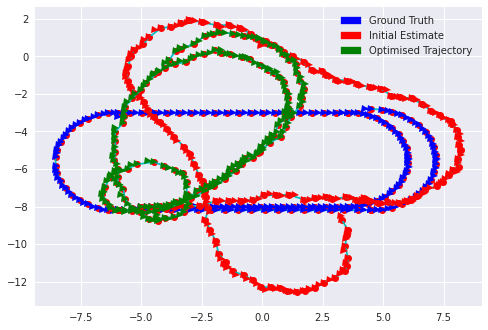

Iteration :  21 ,Error :  [464.79474]
Iteration :  22 ,Error :  [464.8124]
Iteration :  23 ,Error :  [464.82318]
Iteration :  24 ,Error :  [464.82947]
Iteration :  25 ,Error :  [464.83292]
Iteration :  26 ,Error :  [464.8349]
Iteration :  27 ,Error :  [464.83588]
Iteration :  28 ,Error :  [464.8363]
Iteration :  29 ,Error :  [464.83655]
Iteration :  30 ,Error :  [464.8367]


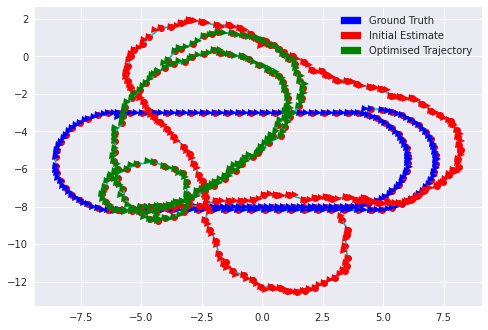

Iteration :  31 ,Error :  [464.83676]
Iteration :  32 ,Error :  [464.83685]
Iteration :  33 ,Error :  [464.83688]
Iteration :  34 ,Error :  [464.83685]
Iteration :  35 ,Error :  [464.83682]
Iteration :  36 ,Error :  [464.837]
Iteration :  37 ,Error :  [464.837]
Iteration :  38 ,Error :  [464.8371]
Iteration :  39 ,Error :  [464.83722]
Iteration :  40 ,Error :  [464.8372]


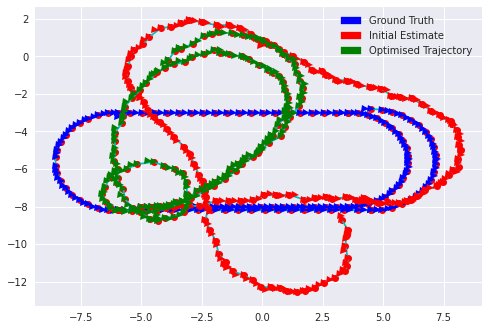

Iteration :  41 ,Error :  [464.8372]
Iteration :  42 ,Error :  [464.83755]
Iteration :  43 ,Error :  [464.8377]
Iteration :  44 ,Error :  [464.8378]
Iteration :  45 ,Error :  [464.83777]
Iteration :  46 ,Error :  [464.8379]
Iteration :  47 ,Error :  [464.83798]
Iteration :  48 ,Error :  [464.83795]
Iteration :  49 ,Error :  [464.838]
Iteration :  50 ,Error :  [464.8381]


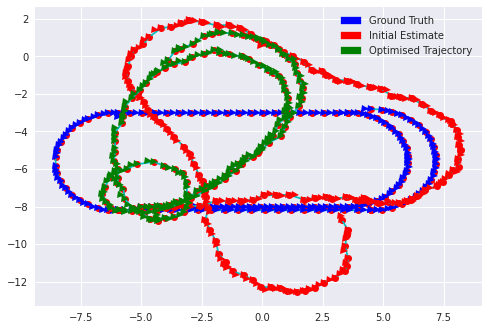

Iteration :  51 ,Error :  [464.8381]
Iteration :  52 ,Error :  [464.83817]
Iteration :  53 ,Error :  [464.83826]
Iteration :  54 ,Error :  [464.8382]
Iteration :  55 ,Error :  [464.8383]
Iteration :  56 ,Error :  [464.8382]
Iteration :  57 ,Error :  [464.8383]
Iteration :  58 ,Error :  [464.83832]
Iteration :  59 ,Error :  [464.83826]
Iteration :  60 ,Error :  [464.83838]


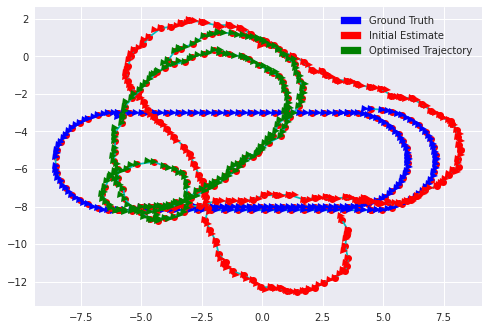

Iteration :  61 ,Error :  [464.83844]
Iteration :  62 ,Error :  [464.83844]
Iteration :  63 ,Error :  [464.83853]
Iteration :  64 ,Error :  [464.8385]
Iteration :  65 ,Error :  [464.83847]
Iteration :  66 ,Error :  [464.8387]
Iteration :  67 ,Error :  [464.83878]
Iteration :  68 ,Error :  [464.83884]
Iteration :  69 ,Error :  [464.83887]
Iteration :  70 ,Error :  [464.83878]


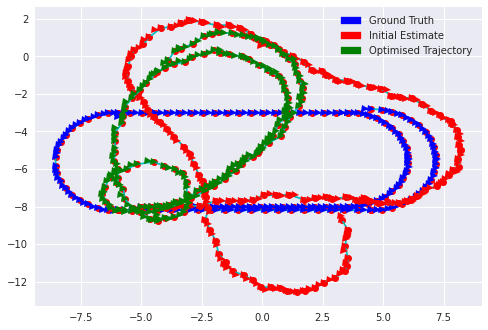

Iteration :  71 ,Error :  [464.83887]
Iteration :  72 ,Error :  [464.8388]
Iteration :  73 ,Error :  [464.8389]
Iteration :  74 ,Error :  [464.83893]
Iteration :  75 ,Error :  [464.839]
Iteration :  76 ,Error :  [464.839]
Iteration :  77 ,Error :  [464.839]
Iteration :  78 ,Error :  [464.83902]
Iteration :  79 ,Error :  [464.83908]
Iteration :  80 ,Error :  [464.83905]


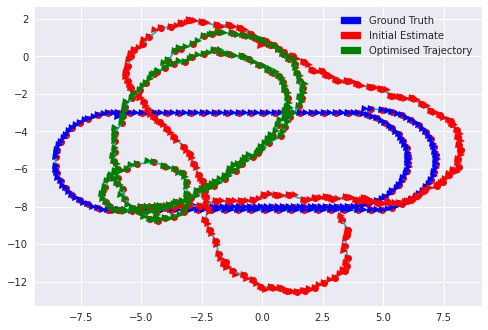

Iteration :  81 ,Error :  [464.83905]
Iteration :  82 ,Error :  [464.83914]
Iteration :  83 ,Error :  [464.8391]
Iteration :  84 ,Error :  [464.8394]
Iteration :  85 ,Error :  [464.8395]
Iteration :  86 ,Error :  [464.8395]
Iteration :  87 ,Error :  [464.83954]
Iteration :  88 ,Error :  [464.83963]
Iteration :  89 ,Error :  [464.83963]
Iteration :  90 ,Error :  [464.8398]


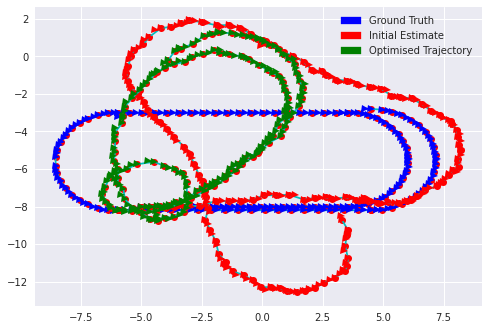

Iteration :  91 ,Error :  [464.8398]
Iteration :  92 ,Error :  [464.84003]
Iteration :  93 ,Error :  [464.83997]
Iteration :  94 ,Error :  [464.84024]
Iteration :  95 ,Error :  [464.8403]
Iteration :  96 ,Error :  [464.84042]
Iteration :  97 ,Error :  [464.8404]
Iteration :  98 ,Error :  [464.8404]
Iteration :  99 ,Error :  [464.84067]


In [12]:
poses,error = optimize(pose_init,edges,anchor,inf_matrix)

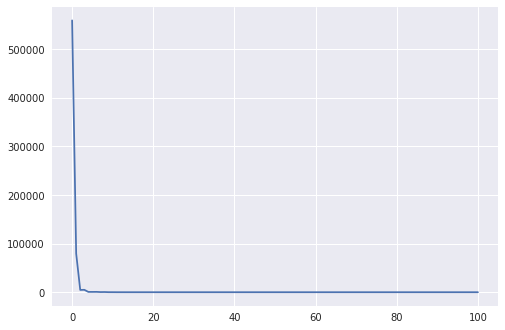

In [25]:
import numpy as np
plt.plot(np.squeeze(error))

This is the default optimization with the following weights :

Anchor = 1000 <br>
Odomerty = 500 <br>
Loop Closure = 700

More experimentation and the best optimized trajectory is explored after verification of the jacobian

## Verification with the auto differenciation

In [13]:
def res_jax(pose,edges,anchor):
    '''The residual function used in the original code is of the shape 140x3, whereas the jax function 
    expects a column to compute the differenciation. Thus this function is used'''
    f = []

    # Anchor Condition
    f.extend(list(pose[0] - anchor))

    # Going using current pose difference and coming back using odometry to get the error
    for i in range(edges[0].shape[0]):
        theta = pose[edges[0][i]][-1] # Current Angle
        x = pose[edges[0][i]][0] + edges[2][i]*jnp.cos(theta) - edges[3][i]*jnp.sin(theta)
        y = pose[edges[0][i]][1] + edges[2][i]*jnp.sin(theta) + edges[3][i]*jnp.cos(theta)
        th2 = theta + edges[4][i]
        estimate = jnp.array([ x,y,th2])

        f.extend(list(estimate - pose[edges[1][i]]))
    
    #print(f)
    return jnp.array(f)

## Checking equivalence

Checking the equivalence of the two residual functions

In [14]:
pose_jax = pose_init.T

In [15]:
res = res_jax(pose_jax,edges,anchor).reshape((-1,1))
res_orig = res_fn(edges,pose_init,anchor).T.reshape((-1,1))

In [16]:
print(jnp.all(res==res_orig))

True


Thus it can be seen that the two residual functions are equivalent

## Equivalence of Jacobians

In [17]:
pose_jax = pose_init.T
get_jacobian = jax.jacfwd(res_jax, argnums=0)
J_jax = get_jacobian(pose_jax,edges, anchor)
J_jax = J_jax.reshape((420, -1, 1))[:, :, 0]

In [18]:
J_computed = jacobian(pose_init, edges)

In [19]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

Frobenius norm between theirs and ours is: 0.0
None


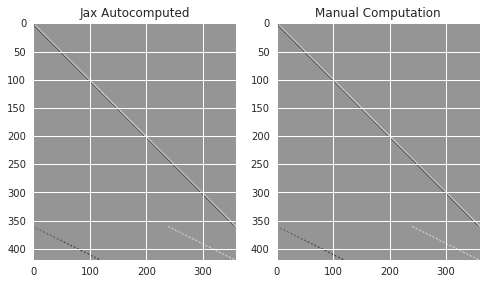

In [20]:
print(frobNorm(J_jax, J_computed, 'theirs', 'ours'))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(J_jax)
ax[0].set_title('Jax Autocomputed')
ax[1].imshow(J_computed)
ax[1].set_title('Manual Computation')
plt.show()

## Experimentation with Weights

It is known that the anchor and the loop closure constraints are much more stricter than odometry, but odometry is the only one that gives and idea of the shape of the trajectory. Thus $W_{odo} < W_{loop}$ and $W_{odo} < W_{anchor}$ but not by too much

In [18]:
def get_info_matrix(odo,loop,anchor):
    diag = []

    # Anchor
    diag.extend([anchor]*3)

    # Odometry
    diag.extend([odo]*119*3)

    # Loop Closure
    diag.extend([loop]*20*3)

    return jnp.diag(jnp.asarray(diag))

### Exp 1:

$W_{odo} = 500$
$W_{loop} = 2000$
$W_{anchor} = 2000$

In [ ]:
inf1 = get_info_matrix(500,2000,2000)
pose1,error1 = optimize(pose_init,edges,anchor,inf1,verbose=False)

The minimum error acheived :  [[601.2575]]


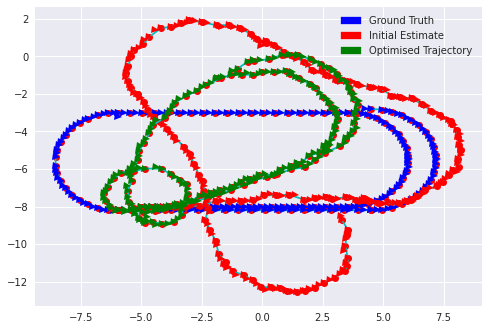

In [33]:
best_error = jnp.argmin(jnp.asarray(error1))
print('The minimum error acheived : ',error1[best_error])
draw_all(pose_init,pose1[best_error][0],pose1[best_error][1],pose1[best_error][2])

It can be seen that the error actually increased. It can be seen that loop constraints are given too much importance which enables them to completely derail the trajectory.

$\therefore$ Reduce $W_{loop}$

In [38]:
inf2 = get_info_matrix(500,1000,2000)
pose2,error2 = optimize(pose_init,edges,anchor,inf2,verbose=False)

The minimum error acheived :  [[498.19202]]


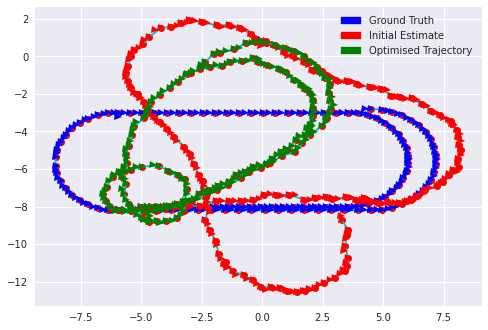

In [39]:
best_error = jnp.argmin(jnp.asarray(error2))
print('The minimum error acheived : ',error2[best_error])
draw_all(pose_init,pose2[best_error][0],pose2[best_error][1],pose2[best_error][2])

After a substantial reduction to the loop closure weight, there is a considerable reduction in error.So one more attempt is made to reduce the loop closure as it can be still seen that the loop contraint is pulling the complete trajectory

In [37]:
inf3 = get_info_matrix(500,500,2000)
pose3,error3 = optimize(pose_init,edges,anchor,inf3,verbose=False)

The minimum error acheived :  [[439.55817]]


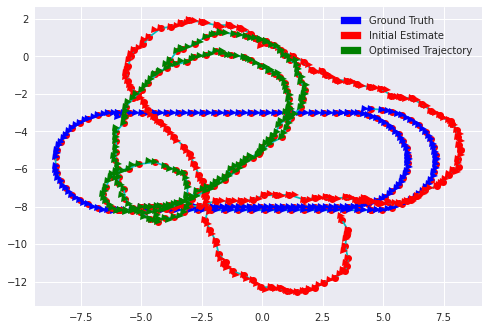

In [40]:
best_error = jnp.argmin(jnp.asarray(error3))
print('The minimum error acheived : ',error3[best_error])
draw_all(pose_init,pose3[best_error][0],pose3[best_error][1],pose3[best_error][2])

It can be seen that this time the error reduction is not that much as compared to the reduction in loop weight. But the error is still high. According to the initial assumption, weight of loop has to be higher than the odometry one. So now odometry constraint will be decreased

In [41]:
inf4 = get_info_matrix(100,500,2000)
pose4,error4 = optimize(pose_init,edges,anchor,inf4,num_iters=20,verbose=False)

The minimum error acheived :  [[133.80022]]


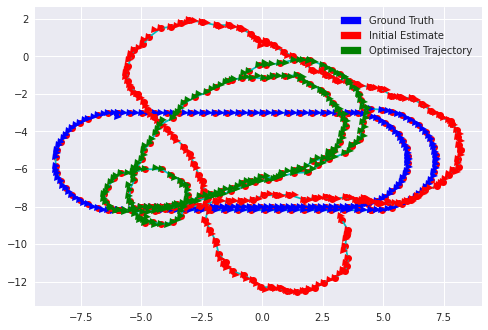

In [42]:
best_error = jnp.argmin(jnp.asarray(error4))
print('The minimum error acheived : ',error4[best_error])
draw_all(pose_init,pose4[best_error][0],pose4[best_error][1],pose4[best_error][2])

There is a substantial derecease in loss, so the reduction will be tried once more. It can be seen that the error function stabilizes after 20 iterations, thus num_iters is set to 20 from now on. The error function is plotted after the experiments for confirmation

In [43]:
inf5 = get_info_matrix(70,500,2000)
pose5,error5 = optimize(pose_init,edges,anchor,inf5,num_iters=20,verbose=False)

The minimum error acheived :  [[108.577034]]


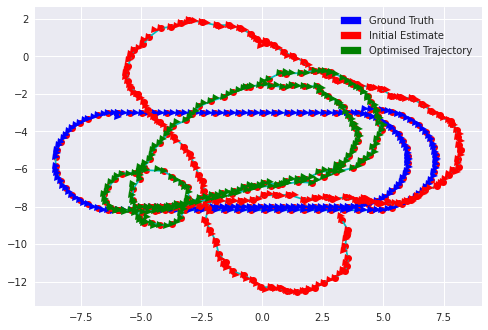

In [44]:
best_error = jnp.argmin(jnp.asarray(error5))
print('The minimum error acheived : ',error5[best_error])
draw_all(pose_init,pose5[best_error][0],pose5[best_error][1],pose5[best_error][2])

There is still a reduction in error, so the odometry weight is reduced once more

In [45]:
inf6 = get_info_matrix(40,500,2000)
pose6,error6 = optimize(pose_init,edges,anchor,inf6,num_iters=20,verbose=False)

The minimum error acheived :  [[83.17094]]


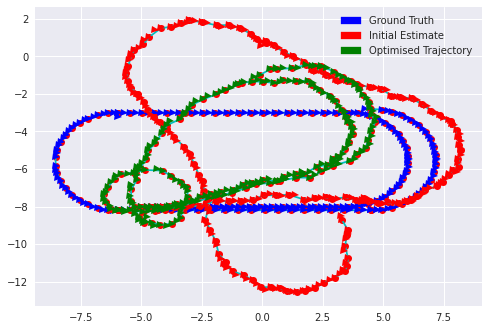

In [49]:
best_error = jnp.argmin(jnp.asarray(error6))
print('The minimum error acheived : ',error6[best_error])
draw_all(pose_init,pose6[best_error][0],pose6[best_error][1],pose6[best_error][2])

The error is still decreasing, so the odometry weight will be decreased again.

In [50]:
inf7 = get_info_matrix(20,500,2000)
pose7,error7 = optimize(pose_init,edges,anchor,inf7,num_iters=20,verbose=False)

The minimum error acheived :  [[63.75114]]


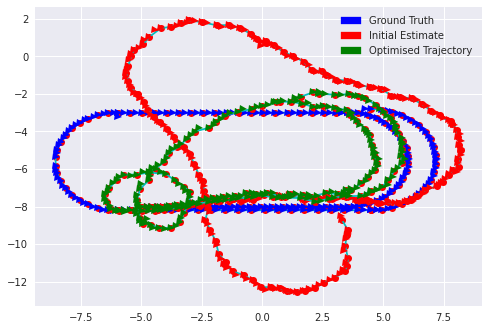

In [51]:
best_error = jnp.argmin(jnp.asarray(error7))
print('The minimum error acheived : ',error7[best_error])
draw_all(pose_init,pose7[best_error][0],pose7[best_error][1],pose7[best_error][2])

There is still a reduction, so the odometry weight is decreased.

In [52]:
inf8 = get_info_matrix(10,500,2000)
pose8,error8 = optimize(pose_init,edges,anchor,inf8,num_iters=20,verbose=False)

The minimum error acheived :  [[54.4578]]


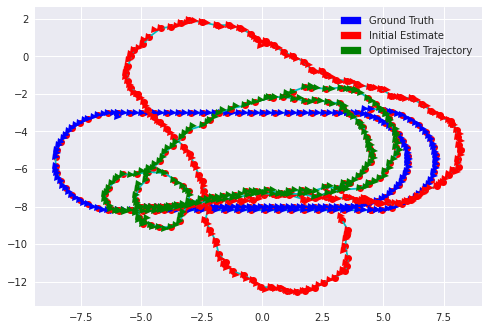

In [53]:
best_error = jnp.argmin(jnp.asarray(error8))
print('The minimum error acheived : ',error8[best_error])
draw_all(pose_init,pose8[best_error][0],pose8[best_error][1],pose8[best_error][2])

In [55]:
inf9 = get_info_matrix(5,500,2000)
pose9,error9 = optimize(pose_init,edges,anchor,inf9,num_iters=30,verbose=False)

The minimum error acheived :  [[49.792854]]


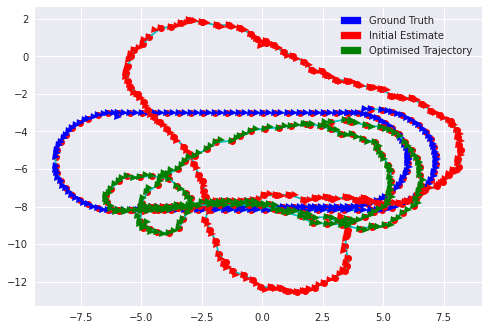

In [56]:
best_error = jnp.argmin(jnp.asarray(error9))
print('The minimum error acheived : ',error9[best_error])
draw_all(pose_init,pose9[best_error][0],pose9[best_error][1],pose9[best_error][2])

In [57]:
inf10 = get_info_matrix(1,500,2000)
pose10,error10 = optimize(pose_init,edges,anchor,inf10,num_iters=30,verbose=False)

The minimum error acheived :  [[45.022423]]


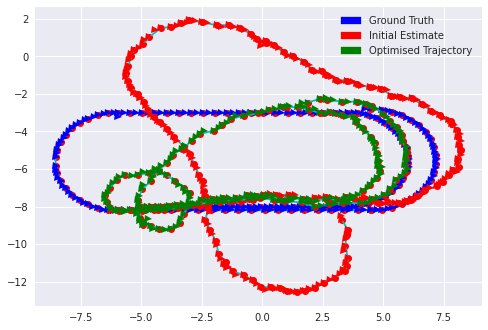

In [58]:
best_error = jnp.argmin(jnp.asarray(error10))
print('The minimum error acheived : ',error10[best_error])
draw_all(pose_init,pose10[best_error][0],pose10[best_error][1],pose10[best_error][2])

In [61]:
inf11 = get_info_matrix(0.5,500,2000)
pose11,error11 = optimize(pose_init,edges,anchor,inf11,num_iters=30,verbose=False)

The minimum error acheived :  [[45.026123]]


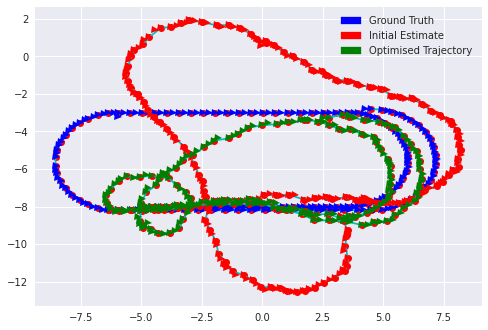

In [62]:
best_error = jnp.argmin(jnp.asarray(error11))
print('The minimum error acheived : ',error11[best_error])
draw_all(pose_init,pose11[best_error][0],pose11[best_error][1],pose11[best_error][2])

The decrease in odometry weight does nothing so now will experiment with anchor weight

In [77]:
inf12 = get_info_matrix(0.5,500,500)
pose12,error12 = optimize(pose_init,edges,anchor,inf12,num_iters=30,verbose=False)

The minimum error acheived :  [[40.65875]]


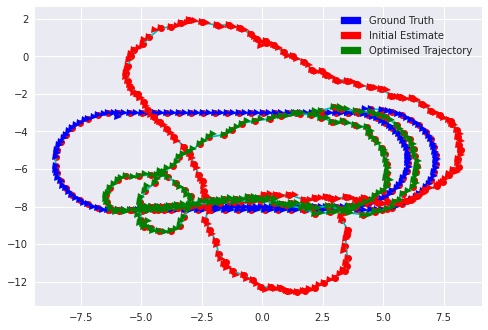

In [78]:
best_error = jnp.argmin(jnp.asarray(error12))
print('The minimum error acheived : ',error12[best_error])
draw_all(pose_init,pose12[best_error][0],pose12[best_error][1],pose12[best_error][2])

The decrease in anchor weight does help. So the initial guess was correct that weight of odometry is very less as compared to the weight of loop contraints and anchor, but the magnitude of decrease was missed, as the difference is in the order of hundreds rather than tens as it was previously thought

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

The residual computed is a vector with the length of (no_anchors + no_odometry_constraints + no_loop_constraints)\*3. This is the case as residual[i,j] = estimate of j from i - pose[i]. Thus it is 3 vector for a single contraint. Thus the complete residual is (constraints\*3).

Jacobian is the derivative of residual with respect to every variable. Thus the jacobian will have the shape of (constraint\*3,no_of_poses*3). The shape[0] is due to the shape of the residual and the shape[2] is because each pose has 3 variables and thus the total number of variables is 3\*no_of_poses

The optimization process is a simple lm with lambda changing upon th nature of error. The observation is that the trajectory is highly dependant on the information matrix, and that odometry is too error prone and thus should be given a considerably less weight as compared to loop constraints and anchor constraints.

The indermideate plots tell an interesting story as it does not immideately come to ground truth like trajectory but rather goes through an extreme transformation which is highly dependant on the weight matrix

One other thing is that the time taken to omptimize is very less and in the range of 20-30 steps

## Extra

The error plots

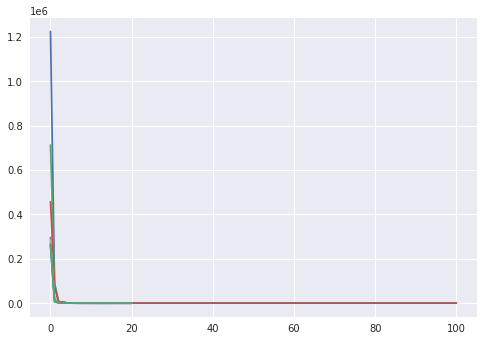

In [74]:
plt.plot(np.squeeze(error1))
plt.plot(np.squeeze(error2))
plt.plot(np.squeeze(error3))
plt.plot(np.squeeze(error4))
plt.plot(np.squeeze(error5))
plt.plot(np.squeeze(error6))
plt.plot(np.squeeze(error7))
plt.plot(np.squeeze(error8))

It can be seen that the plots collapse and optimize under 30 steps

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [82]:
def g2o_writer(pose,file_name):
    with open(file_name, 'w') as f:
        for i in range(pose.shape[0]):
            st = "VERTEX_SE2 " + str(i) + " " + str(pose[i][0]) + " " + str(pose[i][1]) + " " + str(pose[i][2])
            f.write("%s\n" % st)

        f2 = open('../data/edges.txt', 'r')
        A = f2.readlines()
        f2.close()
        
        for line in A:
            if "VERTEX_SE2" not in line:
                f.write("%s" % line)

In [84]:
g2o_writer(pose12[best_error],'opt.g2o')